# Test for simulated EEG

Authors          : Guillaume Dumas

Date            : 2020-07-09

## Load useful libs

### Core

In [39]:
from pathlib import Path
from copy import copy
from collections import OrderedDict

### Data science

In [40]:
import numpy as np
import scipy
from scipy.integrate import odeint

### Visualization

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl3d # pip install git+https://github.com/rougier/matplotlib-3d
from mpl3d import glm
from mpl3d.mesh import Mesh
from mpl3d.camera import Camera

### MNE

In [41]:
import mne

### HyPyP

In [42]:
from hypyp import prep # need pip install https://api.github.com/repos/autoreject/autoreject/zipball/master
from hypyp import analyses
from hypyp import stats
from hypyp import viz
from hypyp import utils

## Setting parameters

Frequency bands used in the study

In [43]:
freq_bands = {'Theta': [4, 7],
              'Alpha-Low': [7.5, 11],
              'Alpha-High': [11.5, 13],
              'Beta': [13.5, 29.5],
              'Gamma': [30, 48]}

Keep the order of frequency bands in the dictionary

In [44]:
freq_bands = OrderedDict(freq_bands)

## Load data

Loading datasets (see MNE functions mne.io.read_raw_format), convert them to MNE Epochs.

In our example, we load Epochs directly from EEG dataset in the fiff format

In [45]:
epo1 = mne.read_epochs(
    Path('../data/participant1-epo.fif').resolve(),
    preload=True,
)

epo2 = mne.read_epochs(
    Path('../data/participant2-epo.fif').resolve(),
    preload=True,
)

Reading /Users/ayrolles/DEV/HyPyP/data/participant1-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/ayrolles/DEV/HyPyP/data/participant2-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated


Since our example dataset was not initially dedicated to hyperscanning, we need to equalize the number of epochs between our two participants.

In [46]:
mne.epochs.equalize_epoch_counts([epo1, epo2])

Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

Specify sampling frequency

In [47]:
sampling_rate = epo1.info['sfreq'] #Hz

## Generate random epochs

In [48]:
epo_real = utils.merge(epoch_S1=epo1, epoch_S2=epo2)

Not setting metadata
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [49]:
epo_rnd = utils.generate_random_epoch(epoch=epo_real, mu=0.0, sigma=2.0)

Not setting metadata
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [50]:
n_epo, n_chan, n_samp = epo_real.get_data(copy=False).shape

In [51]:
sfreq = epo_real.info['sfreq']

## Generate coupled oscillators

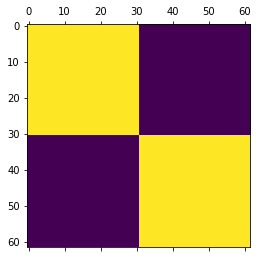

In [52]:
frequency_mean = 10.  # Hz
frequency_std = 0.2 # Hz

noise_phase_level = 0.005 / n_samp
noise_amplitude_level = 0.

N = int(n_chan/2)
A11 = 1 * np.ones((N, N))
A12 = 0 * np.ones((N, N))
A21 = 0 * np.ones((N, N))
A22 = 1 * np.ones((N, N))
W = np.block([[A11, A12], [A21, A22]])
W = 0.2 * W
plt.matshow(W)

In [57]:
Nt = n_samp * n_epo
tmax = n_samp / sfreq * n_epo  # s
tv = np.linspace(0., tmax, Nt)

freq = frequency_mean + frequency_std * np.random.randn(n_chan)
omega = 2. * np.pi * freq

def fp(p, t):
    p = np.atleast_2d(p)
    coupling = np.squeeze((np.sin(p) * np.matmul(W, np.cos(p).T).T) - (np.cos(p) * np.matmul(W, np.sin(p).T).T))
    dotp = omega - coupling + noise_phase_level * np.random.randn(n_chan)
    return dotp

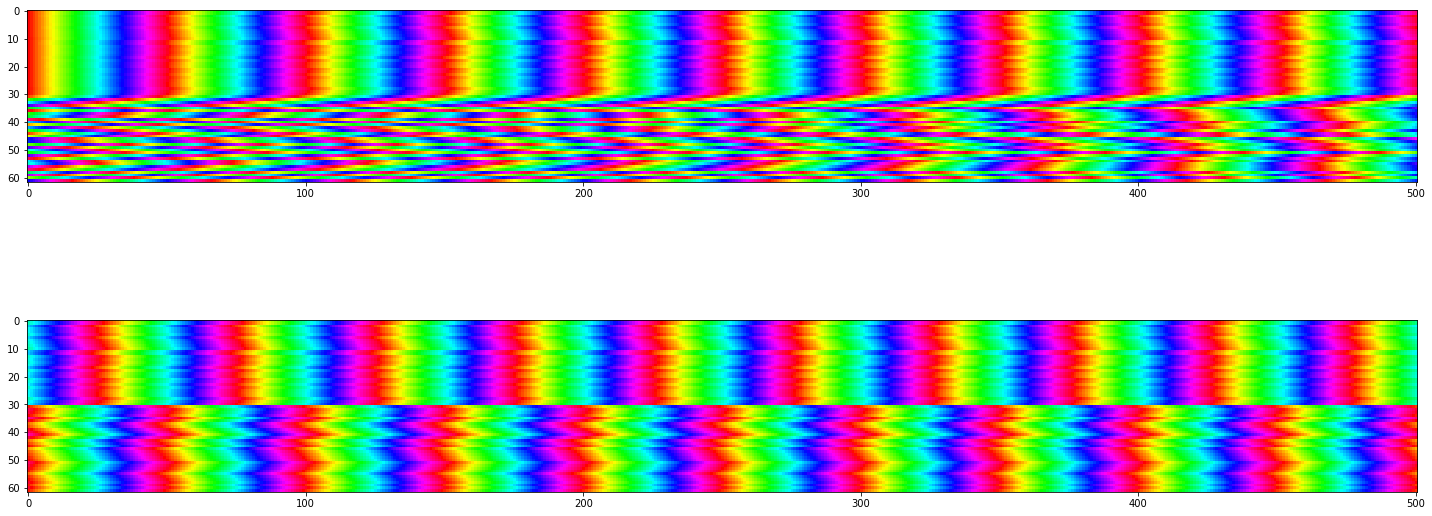

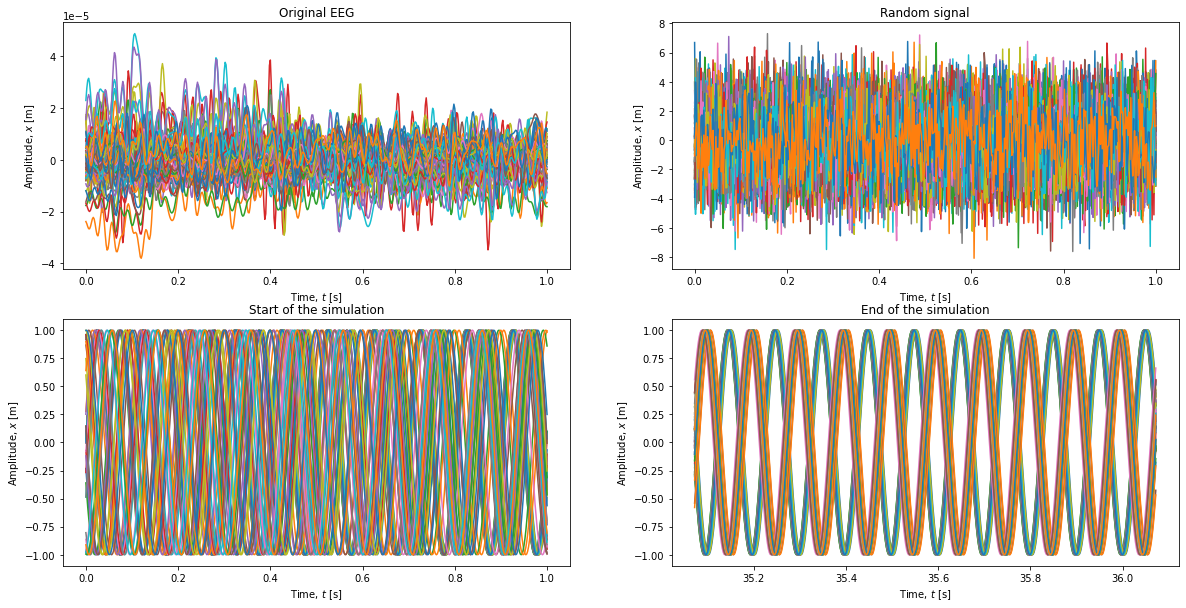

CPU times: user 10.3 s, sys: 876 ms, total: 11.2 s
Wall time: 7.78 s


In [58]:
%%time
p0 = 2 * np.pi * np.block([np.zeros(N), np.zeros(N) + np.random.rand(N) + 0.5])
Phi = odeint(fp, p0, tv) % (2*np.pi)

plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.imshow(Phi[:n_samp, :].T,interpolation='none', cmap='hsv')
plt.subplot(2,1,2)
plt.imshow(Phi[-n_samp:, :].T,interpolation='none', cmap='hsv')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
plt.plot(tv[:n_samp], np.squeeze(epo_real[0]._data.T), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.title('Original EEG')
plt.subplot(2,2,2)
plt.plot(tv[:n_samp], np.squeeze(epo_rnd[0]._data).T, "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.title('Random signal')
plt.subplot(2,2,3)
plt.plot(tv[:n_samp], np.sin(Phi[:n_samp, :]), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.title('Start of the simulation')
plt.subplot(2,2,4)
plt.plot(tv[-n_samp:], np.sin(Phi[-n_samp:, :]), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.title('End of the simulation')
plt.show()

In [55]:
N = int(n_chan/2)
A11 = 1 * np.ones((N, N))
A12 = 0 * np.ones((N, N))
A21 = 0 * np.ones((N, N))
A22 = 1 * np.ones((N, N))
W = np.block([[A11, A12], [A21, A22]])
W = 0.2 * W

def virtual_dyad(epochs = epo_real, frequency_mean = 10., frequency_std = 0.2, noise_phase_level = 0.005, noise_amplitude_level = 0.1, W = W):
    n_epo, n_chan, n_samp = epochs.get_data(copy=False).shape
    sfreq = epochs.info['sfreq']

    Nt = n_samp * n_epo
    tmax = n_samp / sfreq * n_epo  # s
    tv = np.linspace(0., tmax, Nt)

    freq = frequency_mean + frequency_std * np.random.randn(n_chan)
    omega = 2. * np.pi * freq

    def fp(p, t):
        p = np.atleast_2d(p)
        coupling = np.squeeze((np.sin(p) * np.matmul(W, np.cos(p).T).T) - (np.cos(p) * np.matmul(W, np.sin(p).T).T))
        dotp = omega - coupling + noise_phase_level * np.random.randn(n_chan) / n_samp
        return dotp

    p0 = 2 * np.pi * np.block([np.zeros(N), np.zeros(N) + np.random.rand(N) + 0.5])
    
    phi = odeint(fp, p0, tv) % (2*np.pi)
    eeg = np.sin(phi) + noise_amplitude_level * np.random.randn(*phi.shape)
    
    simulation = epo_real.copy()
    simulation._data = np.transpose(np.reshape(eeg.T, [n_chan, n_epo, n_samp]), (1, 0, 2))
    
    return simulation

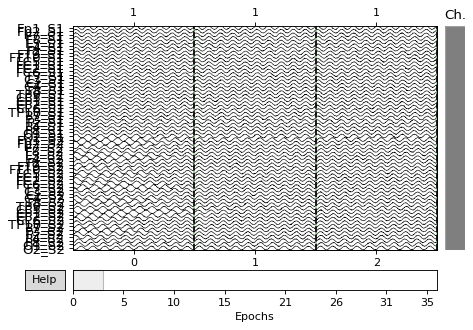

In [56]:
sim = virtual_dyad(epochs = epo_real, frequency_mean = 10., frequency_std = 0.2, noise_phase_level = 0.005, noise_amplitude_level = 0.1, W = W)
sim.plot(scalings=5, n_epochs=3, n_channels=62)
plt.show()